In [1]:
# Importing pycocotools
import pycocotools

In [2]:
# Changing the the directory where all modules are saved.
import os
os.chdir(r'C:\Users\vladi\OneDrive\Desktop\Sigmoid\CV\Object detection\object detection\object detection\utils')

In [3]:
# Importing all needed libraries.
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

from engine import train_one_epoch, evaluate
import utils
import transforms as T
from PIL.ExifTags import TAGS, GPSTAGS

c:\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
def parse_one_annot(path_to_data_file, filename):
    '''
        This function reads the csv file and returns the pair (filename, box coordinated)
    :param path_to_data_file: str
        The path to the csv file.
    :param filename: str
        The name of the image.
    :raturn: numpy array
    '''
    data = pd.read_csv(path_to_data_file,engine='python')
    boxes_array = data[data['image_path']==filename][['x_min', 'y_min', 'x_max', 'y_max']].values
    return boxes_array

In [5]:
class FIX1_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        '''
            The FIX1_Dataset constructor.
        :param root: str
            The root folder with the images.
        :param data_file: str
            The the path to the csv file with the coordinates of the objects in images.
        :param transform: pytorch transformer
            The PyTorch transformer fo images.
        '''
        # Setting up the parameters.
        self.root = root
        self.transforms = transforms
        # Reading the table from csv file.
        data = pd.read_csv(data_file)
        data = data.sample(frac=1)
        data = data[:10000]
        # Getting the list with paths of the images.
        self.imgs = data['image_path'].values
        # Setting up the data file path.
        self.path_to_data_file = data_file
    def __getitem__(self, idx):
        '''
            Used by object to acces images data from dataframe.
        :param idx: int
            The index of the image.
        '''
        # Getting the full path of the image.
        img_path = os.path.join(self.root, self.imgs[idx])
        # Reading the image as a PIL object.
        img = Image.open(img_path).convert('RGB')
        # Readding the image metadata.
        for orientation in TAGS.keys() : 
            if TAGS[orientation]=='Orientation' : break 
        # Getting the exif
        exif=dict(img.getexif().items())
        # Rotating the image if the orientation is wrong.
#         print(img)
#         print(img.getexif())
        #print(TAGS.keys())
        if len(exif)!=0:
            if orientation in exif.keys():
                if   exif[orientation] == 3 : 
                    img=img.rotate(180, expand=True)
                elif exif[orientation] == 6 : 
                    img=img.rotate(270, expand=True)
                elif exif[orientation] == 8 : 
                    img=img.rotate(90, expand=True)
        
        # Getting the box coordinates for the image.
        box_list = parse_one_annot(self.path_to_data_file, self.imgs[idx])
        # Converting the box coordinates to PyTorch tensor.
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        # Getting the number of objects in the image.
        num_objs = len(box_list)
        # Creating the labels tensor.
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Getting the image id as a PyTorch tensor.
        image_id = torch.tensor([idx])
        # Computing the area of the box.
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        # Setting up the target dictionary.
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        # If any transformation is passed then it is applyed on the image.
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        '''
            This function is triggered when on the object is applyed a len function.
        '''
        return len(self.imgs)

In [6]:
# Creatting and testing the dataset.
dataset = FIX1_Dataset(root = r'D:\programming\ML\Sigmoid\Logo bluring\archive (10)\LogoDet-3K', data_file=r'C:\Users\vladi\OneDrive\Desktop\Sigmoid\CV\Logo bluring\logo_detection_df.csv')
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=494x378 at 0x2948BA00D90>,
 {'boxes': tensor([[ 88., 118., 443., 283.]]),
  'labels': tensor([1]),
  'image_id': tensor([0]),
  'area': tensor([58575.]),
  'iscrowd': tensor([0])})

In [7]:
def get_model(num_classes):
    '''
        This function is used to create a pretrained FastRCNN Model.
    :num_classes: int
        The number of classes. Should be setted n+1 wher n is the number of object to detect.
    '''
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    #get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [8]:
def get_transform(train):
    '''
        Uses to create a transformer.
    :param train: bool
        Decides if to add or not the RandomHorizontalFlip transformation.
    '''
    transforms = []
    # convert the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during the training, randomly flip the trinaing images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [9]:
# Creatting the train and test data sets.
train = FIX1_Dataset(root = r'D:\programming\ML\Sigmoid\Logo bluring\archive (10)\LogoDet-3K', data_file=r'C:\Users\vladi\OneDrive\Desktop\Sigmoid\CV\Logo bluring\logo_detection_df.csv',
                    transforms=get_transform(train=False))
test = FIX1_Dataset(root = r'D:\programming\ML\Sigmoid\Logo bluring\archive (10)\LogoDet-3K', data_file=r'C:\Users\vladi\OneDrive\Desktop\Sigmoid\CV\Logo bluring\logo_detection_df.csv',
                   transforms=get_transform(train=False))

print(train)
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(train)).tolist()
train = torch.utils.data.Subset(train, indices[:9900]) #indices[:int(len(train)*0.0001)
test = torch.utils.data.Subset(test, indices[9900:]) #[int(len(test)*0.0001):int(len(test)*0.0002)]

print(test.dataset)
print(test)
print(len(train.dataset))
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    train, batch_size=1, shuffle=True, num_workers=0,
    collate_fn = utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn
)

print("We have: {} examples - {} training and {} testing".format(len(indices), len(train), len(test)))

10000
We have: 10000 examples - 9900 training and 100 testing


In [10]:
len(data_loader_test.dataset)

100

In [11]:
# Setting the device to the cpu, if you have available gpu, set as 'gpu'
device = torch.device('cuda')

# our dataset has two classes only - racoon and not racoon
num_classes = 2
# get the model using out helper function
model = get_model(num_classes)
# model = loaded_model
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [12]:
# let's train it for 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
    # trian for one epoch, printing every 1- itterations

    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1000)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    print('c')

c:\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [   0/9900]  eta: 8:55:28  lr: 0.000010  loss: 0.7571 (0.7571)  loss_classifier: 0.6124 (0.6124)  loss_box_reg: 0.1016 (0.1016)  loss_objectness: 0.0222 (0.0222)  loss_rpn_box_reg: 0.0208 (0.0208)  time: 3.2453  data: 1.0941  max mem: 1184
Epoch: [0]  [1000/9900]  eta: 3:40:43  lr: 0.005000  loss: 0.2296 (0.2695)  loss_classifier: 0.0904 (0.1086)  loss_box_reg: 0.0787 (0.1075)  loss_objectness: 0.0208 (0.0291)  loss_rpn_box_reg: 0.0205 (0.0244)  time: 1.4770  data: 1.0866  max mem: 1551
Epoch: [0]  [2000/9900]  eta: 3:30:50  lr: 0.005000  loss: 0.2071 (0.2360)  loss_classifier: 0.0715 (0.0933)  loss_box_reg: 0.0777 (0.0934)  loss_objectness: 0.0100 (0.0259)  loss_rpn_box_reg: 0.0095 (0.0235)  time: 3.5656  data: 1.3250  max mem: 1551
Epoch: [0]  [3000/9900]  eta: 4:10:39  lr: 0.005000  loss: 0.1779 (0.2310)  loss_classifier: 0.0675 (0.0884)  loss_box_reg: 0.0623 (0.0879)  loss_objectness: 0.0155 (0.0288)  loss_rpn_box_reg: 0.0142 (0.0258)  time: 1.5632  data: 1.2478  max me

In [13]:
# Creating a folder to save the model.
os.chdir(r'C:\Users\vladi\OneDrive\Desktop\Sigmoid\CV\Logo bluring')
os.mkdir('logo_detection_model')

In [14]:
# Saving the model as a pth file.
torch.save(model.state_dict(), r'C:\Users\vladi\OneDrive\Desktop\Sigmoid\CV\Logo bluring\logo_detection_model\fix1_ports_model.pth')

In [15]:
# Loading the model.
loaded_model = get_model(num_classes=2)
loaded_model.load_state_dict(torch.load(r'C:\Users\vladi\OneDrive\Desktop\Sigmoid\CV\Logo bluring\logo_detection_model\fix1_ports_model.pth'))

<All keys matched successfully>

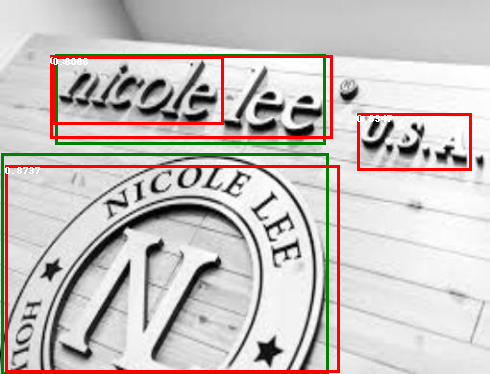

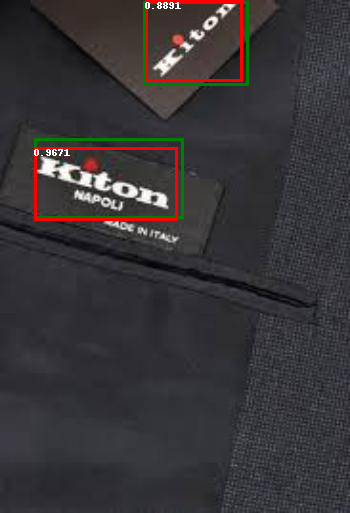

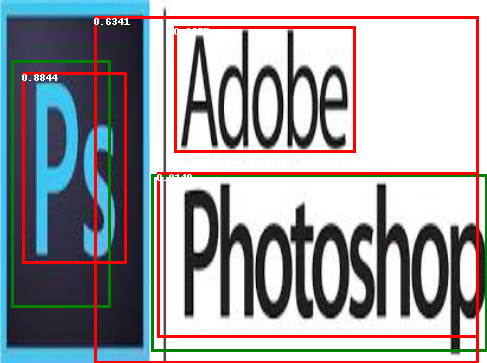

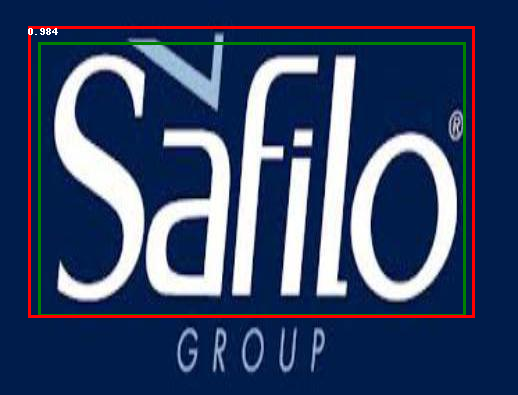

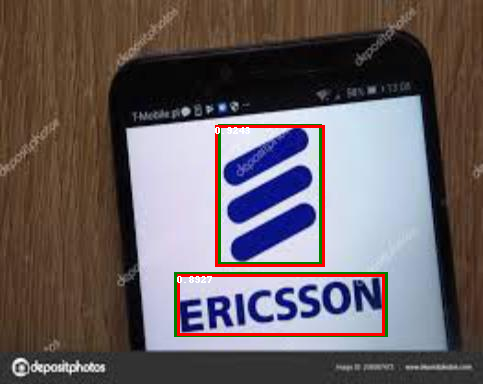

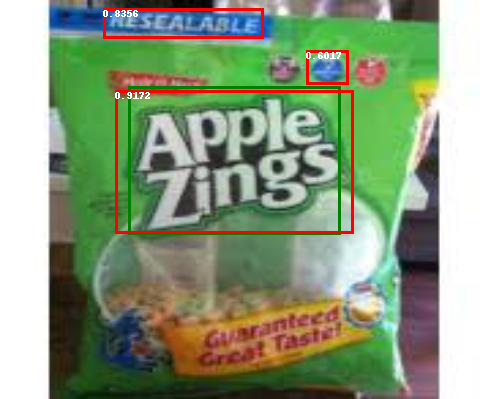

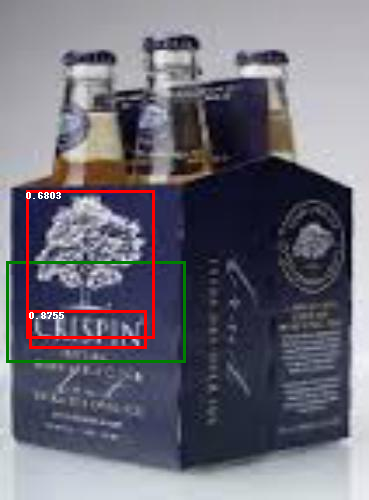

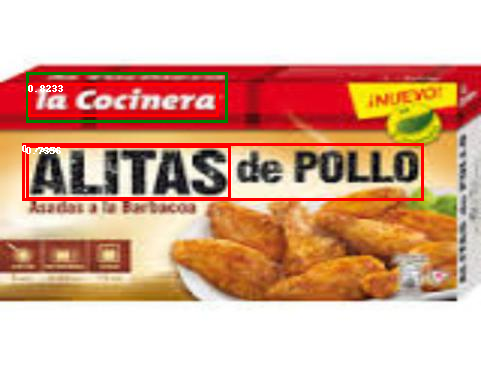

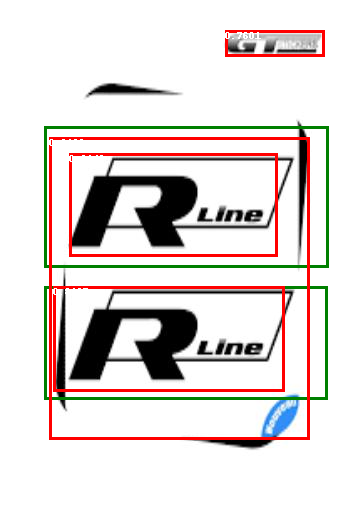

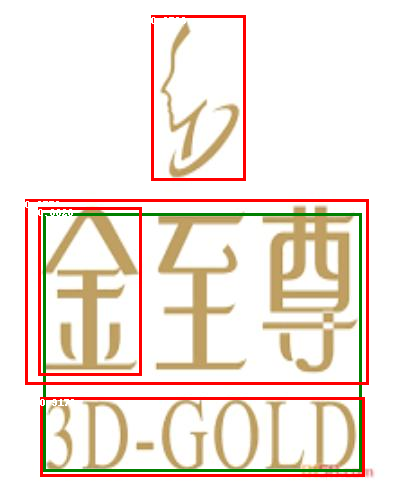

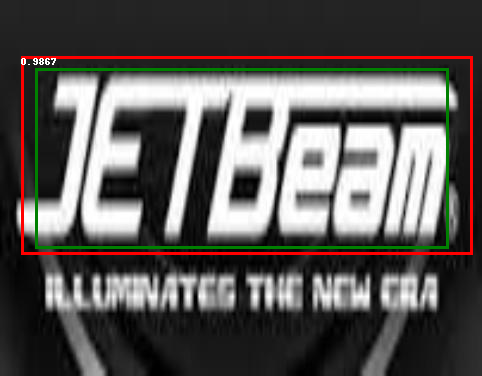

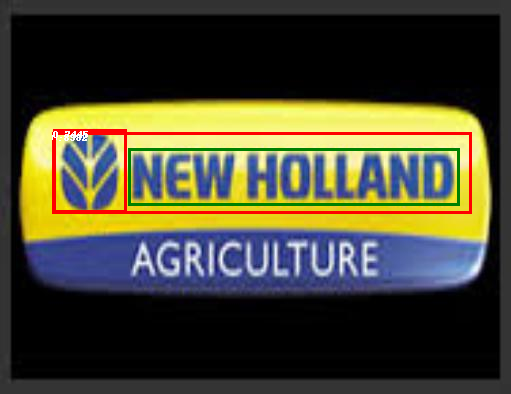

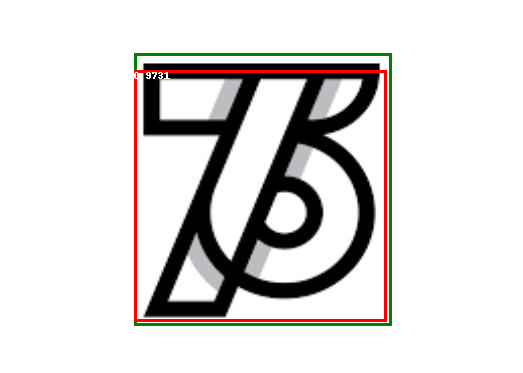

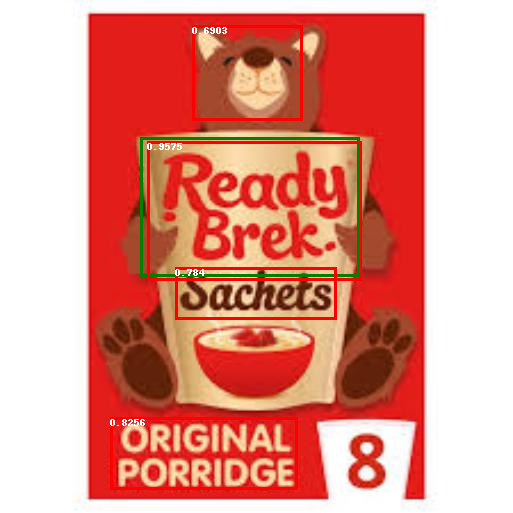

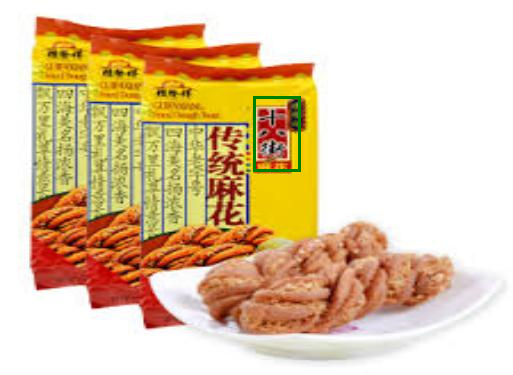

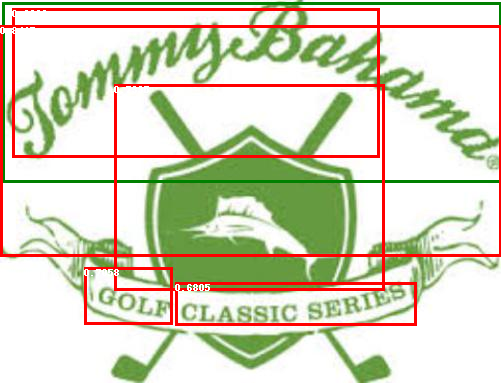

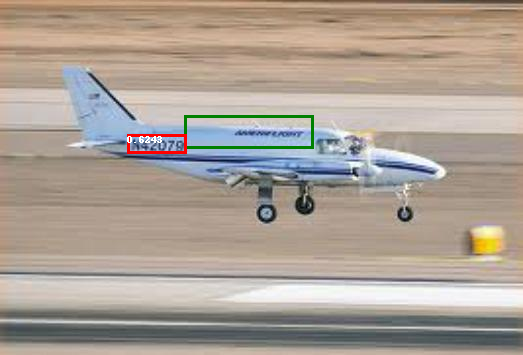

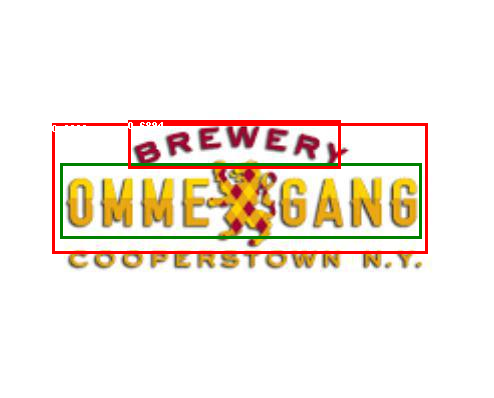

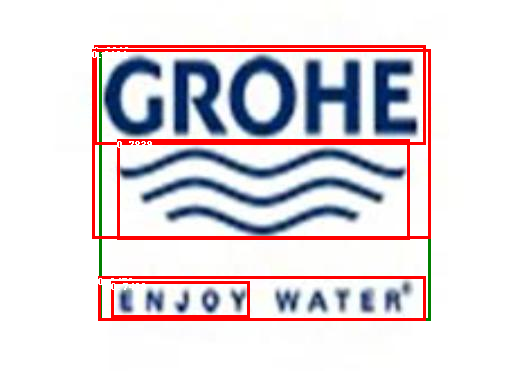

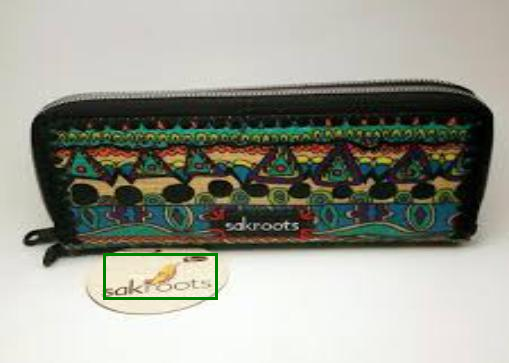

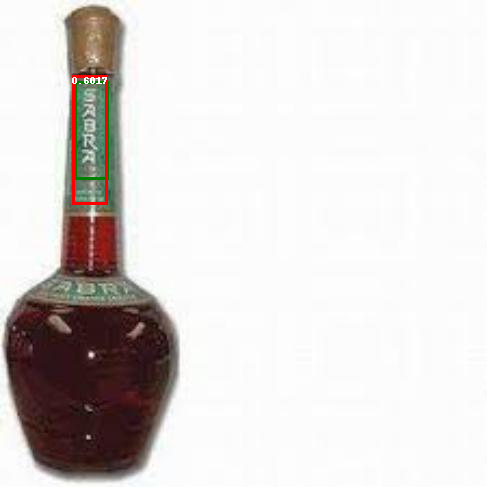

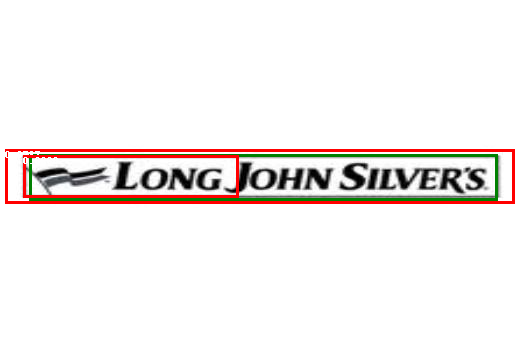

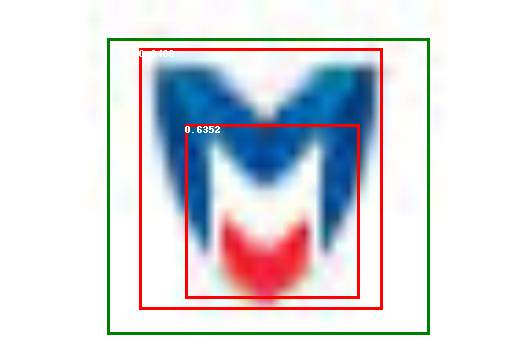

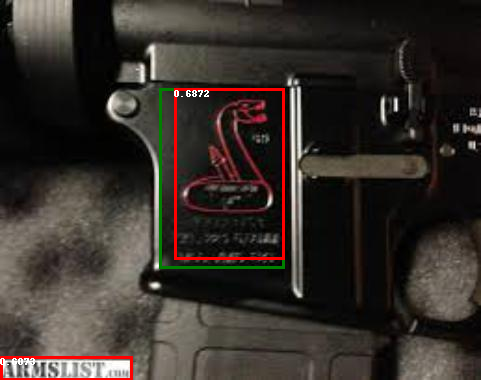

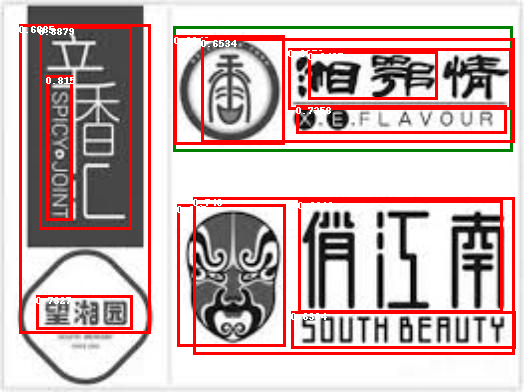

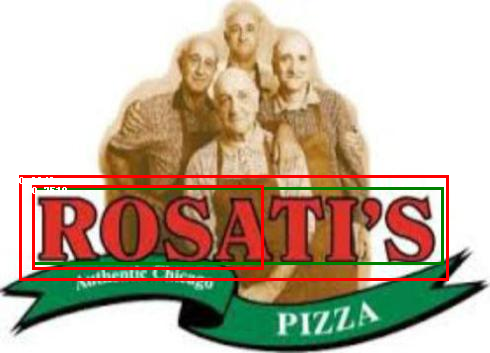

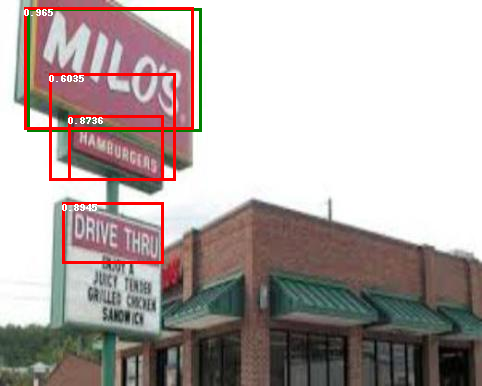

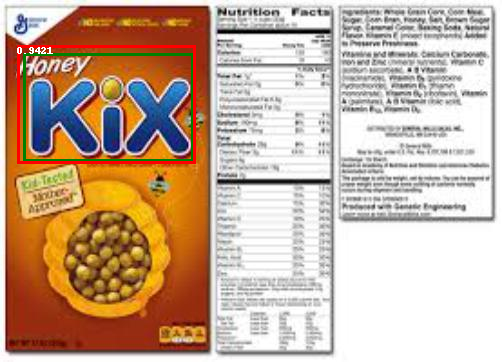

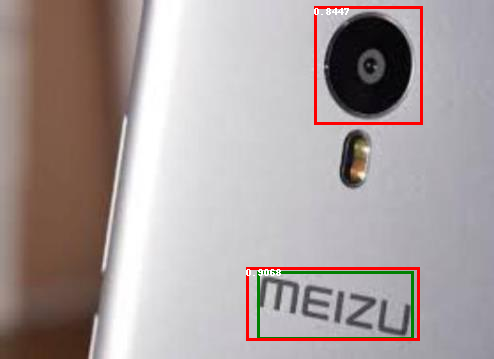

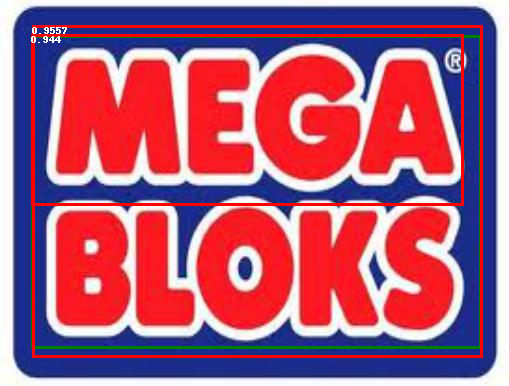

In [25]:
# Use this code to made a predition.
from PIL import ImageDraw
# Getting the image.
for idx in range(20,50):
    img, _ = test[idx]
    # Getting the object coordinates.
    label_boxes = np.array(test[idx][1]['boxes'])

    # Setting the model to eval state.
    loaded_model.eval()
    # Making the prediction.
    with torch.no_grad():
        prediction = loaded_model([img])

    # Getting an drawing the image.
    image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    draw = ImageDraw.Draw(image)

    # Drawing the real box around the object.
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
                       (label_boxes[elem][2], label_boxes[elem][3])],
                      outline='green', width=3)
    # Drawing the predicted box around the object.
    for element in range(len(prediction[0]['boxes'])):
        boxes = prediction[0]['boxes'][element].cpu().numpy()
        score = np.round(prediction[0]['scores'][element].cpu().numpy(), decimals=4)

        if score > 0.6:
            draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],
                         outline='red', width=3)
            draw.text((boxes[0], boxes[1]), text=str(score))
    display(image)

In [17]:
import pandas as pd

dd = pd.read_csv(r'C:\Users\vladi\OneDrive\Desktop\Sigmoid\CV\Logo bluring\logo_detection_df.csv')

In [18]:
dd['image_path']

0                   Clothes\2xist\1.jpg
1                  Clothes\2xist\10.jpg
2                  Clothes\2xist\11.jpg
3                  Clothes\2xist\11.jpg
4                  Clothes\2xist\12.jpg
                      ...              
194708    Transportation\zamboni\42.jpg
194709    Transportation\zamboni\44.jpg
194710    Transportation\zamboni\45.jpg
194711    Transportation\zamboni\46.jpg
194712    Transportation\zamboni\50.jpg
Name: image_path, Length: 194713, dtype: object

In [19]:
# dd.drop('Unnamed: 0',1,inplace=True)

In [20]:
dd

image_path            type  company  x_min  y_min  \
0                 Clothes\2xist\1.jpg         Clothes    2xist    276    143   
1                Clothes\2xist\10.jpg         Clothes    2xist    167    204   
2                Clothes\2xist\11.jpg         Clothes    2xist    189     27   
3                Clothes\2xist\11.jpg         Clothes    2xist      5     46   
4                Clothes\2xist\12.jpg         Clothes    2xist    297    137   
...                               ...             ...      ...    ...    ...   
194708  Transportation\zamboni\42.jpg  Transportation  zamboni    187     49   
194709  Transportation\zamboni\44.jpg  Transportation  zamboni    174     46   
194710  Transportation\zamboni\45.jpg  Transportation  zamboni      1      2   
194711  Transportation\zamboni\46.jpg  Transportation  zamboni    245    220   
194712  Transportation\zamboni\50.jpg  Transportation  zamboni    156    229   

        x_max  y_max  
0         459    184  
1         339    273  
2         335     64  
3         148    129  
4         493    177  
...       ...    ...  
194708    481    162  
194709    478    162  
194710    510    247  
194711    498    301  
194712    318    272  

[194713 rows x 7 columns]

In [21]:
#dd = dd.rename(columns = {'0':'image_path','1':'type','2':'company','3':'xmin','4':'ymin','5':'xmax','6':'ymax'})

In [22]:
# dd = dd.rename(columns = {'xmin':'x_min','ymin':'y_min','xmax':'x_max','ymax':'y_max'})

In [23]:
# dd.to_csv(r'C:\Users\vladi\OneDrive\Desktop\Sigmoid\CV\Logo bluring\logo_detection_df.csv',index = False)